In [80]:
# seeing qiskit stuff that's availible

import qiskit as qk
print(dir(qk))
print()
import qiskit_aer as aer
print(dir(aer))
print()
import qiskit_ibm_runtime as run
print(dir(run))
print()
import qiskit_ibm_experiment as exp
print(dir(exp))

['AncillaRegister', 'ClassicalRegister', 'MissingOptionalLibraryError', 'QiskitError', 'QuantumCircuit', 'QuantumRegister', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_accelerate', '_config', '_numpy_compat', '_user_config', 'assemble', 'assembler', 'circuit', 'compiler', 'converters', 'dagcircuit', 'exceptions', 'generate_preset_pass_manager', 'importlib', 'os', 'passmanager', 'primitives', 'providers', 'pulse', 'qasm3', 'qiskit', 'qobj', 'qpy', 'quantum_info', 'result', 'schedule', 'scheduler', 'sequence', 'synthesis', 'sys', 'transpile', 'transpiler', 'user_config', 'utils', 'version', 'visualization', 'warnings']

['Aer', 'AerError', 'AerJob', 'AerProvider', 'AerSimulator', 'QasmSimulator', 'StatevectorSimulator', 'UnitarySimulator', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'aer_compiler', '

# Interacting Fermions on a 1D Lattice

### Quantum circuit of the Hubbard Hamiltonian for *Variational Quantum Eigensolver*

The goal is to simulate the physics of interacting spin-half farmions on a one-dimensional lattice on a quantum computer. The Hamiltonian of the system is described by the Hubbard model, where in addition to the hopping between lattive sites, fermions with opposite spins interact via an on-site Coulomb potential. The ground state energy and its corresponding wavefunction are to be calculated using a hybrid quantum-classical algorithm called *variational quantum eigensolver* (VQE). Implementation of the quantum circuit of the VQE algorithm in IBM's `Qiskit` quantum computer framework is layed out here. 

## Theory

### Hubbard Model of Interacting Fermions

The system consists of a one-dimensional lattice where each site represents a single atomic orbital accommodating at most two electrons with opposite spins. The spin-up and spin-down electrons interact only on the same site through the Coulomb potential. The figure beloww illustrates a lattive of $M$ orbitals where electrons can *hop* only to their nearest neighoring sites. 

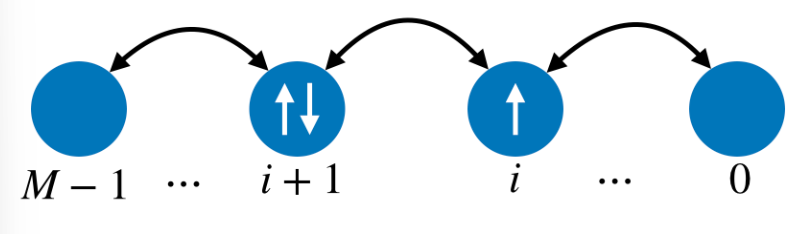

The Hamiltonian of the system, given by the Hubbard model, is written as a sum of non-interacting and interating parts, i.e. $H = H_0 + H_U$, as follows

\begin{equation*}
    H = -t \sum_{\sigma} \sum_{\langle i,j\rangle} a^{\dagger}_{j, \sigma} a_{i, \sigma} + U \sum_{i} \hat{n}_{i, \uparrow} \hat{n}_{i, \downarrow}
\end{equation*}, 

where the variable are defined as 

- $t$ is the hopping energy, proportional to the overlap integral of neighboring orbitals
- $\sigma = \uparrow, \downarrow$ is the spin index
- $\langle i, j\rangle$: site indices where $i$ and $j$ denote adjacent sites
- $a^{\dagger}_{i,\sigma}$, and $a_{i,\sigma}$ are creation and annihilation operators on the $i$-th site
- $U$ is the on-site Coulomb potential/energy
- $\hat{n}_{i, \sigma} = a^{\dagger}_{i,\sigma}a_{i,\sigma}$ is the occuation number operator

Here $t$ and $U$ are the free parameters of the model. The objective is to find the ground state energy and wavefunction of the system with respect to different values of $t$ and $U$. 

### Mapping to Qubits: *Jordan-Wigner Transformation*

To simulate fermions on a quantum computer one needs to utilize a mapping that mimics the exchange statistics of the fermions on the qubits. The *Jordan-Wigner transformation* provides a simple mapping that satifies the symmetrization requirement of fermions. Within this methods, the occupation number of a given orbital is stored as $|0\rangle$ or $|1\rangle$ state of a qubit representing an empty or occupied state respectively. Therefore, for a system with $M$ orbitals, the occupation number representation of $2M$ corresponding qubits (two spins per orbital) is given as 

\begin{equation*}
    |n_{M-1 \downarrow},n_{M-2 \downarrow},...,n_{0\downarrow},n_{M-1 \uparrow},...,n_{M-2 \uparrow},n_{M-1 \uparrow}\rangle
\end{equation*}

where the $M$ qubits (least significant bits) represent the spin-up states and the next $M$ qubits represent the spin-down states and $n_{i \sigma}$ is the occupation number of $i$-th orbital with spins $\sigma = \uparrow, \downarrow$. In this representation, the fermionic creation and annihilation operators are mapped on the following operations on the qubits

\begin{align*}
    a_{i, \sigma} = I_{M-1 \sigma} \otimes ... \otimes I_{i+1 \sigma} \otimes Q_{i \sigma} \otimes Z_{i-1 \sigma} \otimes ... \otimes Z_{0 \sigma} \\
    a^{\dagger}_{i \sigma} = I_{M-1 \sigma} \otimes ... \otimes I_{i+1 \sigma} \otimes Q^{\dagger}_{i \sigma} \otimes Z_{i-1 \sigma} \otimes ... \otimes Z_{0 \sigma}
\end{align*}

where $Q = |0 \rangle \langle 1| = \frac{1}{2}\left(X + iY \right)$ changes the occupation number of the $i$-th site and $Z$ operators recover the sign of the fermionic exchange. Also, $X$, $Y$, and $Z$ represent the Pauli gates. Replacing the creation and annihilation operators with their corresponding qubit operations, the Hamiltonian above can be rewritten in terms of single qubit Pauli gates as follows:

(The non-interacting part of the Hamiltonian $H_0$ consists of hopping terms between adjacent sites, i.e., $a^{\dagger}_{i+1}a_{i} + a^{\dagger}_{i}a_{i+1}$)

\begin{align*}
    a^{\dagger}_{i+1}a_{i} = \left( \frac{X_{i+1} - iY_{i+1}}{2}\right)Z_{i}...Z_{0}\left( \frac{X_{i} + iY_{i}}{2}\right)Z_{i-1}..Z_{0} \\
    = \left( \frac{X_{i+1} - iY_{i+1}}{2}\right) \left( \frac{Z_{i}X_{i} + iZ_{i}Y_{i}}{2} \right) = \left(\frac{X_{i+1} - iY_{i+1}}{2}\right) \left( \frac{X_{i} + iY_{i}}{2} \right) \\
      = \frac{1}{4}\left( iX_{i+1}Y_{i} + X_{i+1}X_{i} + Y_{i+1}Y_{i} - iY_{i+1}X_{i}\right)
\end{align*}

Similarly, 

\begin{align*}
    a^{\dagger}_{i}a_{i+1} = \frac{1}{4}\left( iX_{i}Y_{i+1} + X_{i}X_{i+1} + Y_{i}Y_{i+1} - iY_{i}X_{i+1}\right)
\end{align*}

Therefore, the hopping term between sites $i$ and $i+1$ in terms of Pauli gates are 

\begin{align*}
   a^{\dagger}_{i+1}a_{i} + a^{\dagger}_{i}a_{i+1} = \frac{1}{4}\left(X_{i}X_{i+1} + Y_{i}Y_{i+1}\right)
\end{align*}

The interacting part of the Hamiltonian $H_U$ consists of terms such as $a^{\dagger}_{i\uparrow}a_{i\uparrow}a^{\dagger}_{i\downarrow}a_{i\downarrow}$. Therefore, 

\begin{align*}
        a^{\dagger}_{i\uparrow}a_{i\uparrow} = \left( \frac{X_{i} - iY_{i}}{2} \right)Z_{i-1}...Z_{0}\left( \frac{X_{i} + iY_{i}}{2} \right)Z_{i-1}...Z_{0} = \frac{1}{2}\left( I - Z_{i}\right) \\ a^{\dagger}_{i\uparrow}a_{i\uparrow}a^{\dagger}_{i\downarrow}a_{i\downarrow} = \frac{1}{4}\left( I - Z_{i \uparrow} - Z_{i \downarrow} + Z_{i \uparrow}Z_{i \downarrow}\right)
\end{align*}

Putting these two components of the Hamiltonian together, we get the following:

\begin{multline*}
    H = -\frac{t}{2} \sum_{\sigma} \left[ \sum_{i=2k} X_{i \sigma}X_{i+1 \sigma} + Y_{i \sigma}Y_{i+1 \sigma} + \sum_{i=2k+1} X_{i \sigma}X_{i+1 \sigma} + Y_{i \sigma}Y_{i+1 \sigma} \right] \\
    + \frac{U}{4} \sum_{i}\left( I - Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow} \right)
\end{multline*}

where the ven and odd hopping terms are separated. Although the even and odd terms commute with each other, they require different two-qubit gate configurations in the ansatz circuit.

### Variational Quantum Eigensolver (VQE)

Similar to its classical counterpart, the VQE is a variational method for calculating the ground state energy and wavefunction of a given Hamiltonian. The VQE is a hybrid quantum-classical algorithm where a parameterized ansatz wavefunction is variationally brought to the vicinity of the ground state. The set of parameters that minimize the energy for a given ansatz wavefunction are the solution to the problem. The algorithm consists of two parts: a *quantum circuit* and a *classical optimizer*. The quantum circuit performs two task: first generate the ansatz wavefunction of the system given the variational parameters as the input, and second measure the energy )expectation value of the Hamiltonian_ with respect to that wavefunction. The result of the measurement is then fed into the classical optimizer to generate a new set of variational parameters which hopefullt lead to a lower energy. The following schmatic illustrates the VQE algorithm. 

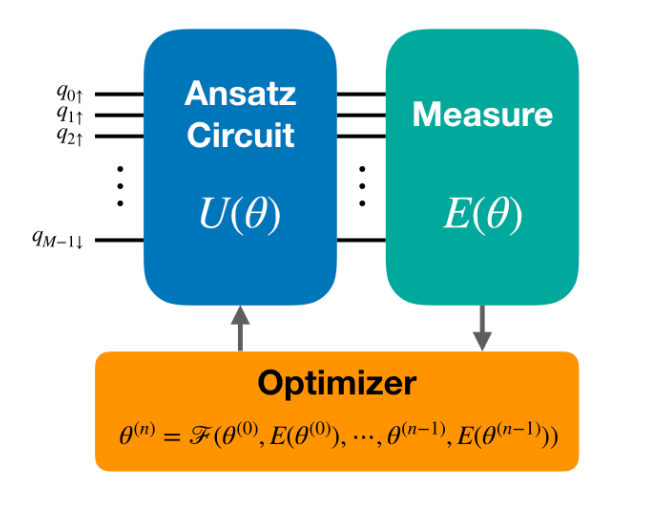

The algorithm starts with a set of variational parameters $\theta^{(0)}$. The ansatz wavefunction $|\psi (\theta^{(0)}) \rangle$ is then generated on the quantum computer by implementing the ansatz circuit represented by the unitary operator $U(\theta^{(0)})$, i.e. $|\psi (\theta^{(0)}) \rangle = U(\theta^{(0)})|\psi_I \rangle$. Here $|\psi_I \rangle$ is the initial wavfunction which is usually chosen to be the ground state of the non-interacting Hamiltonian $H_0$ and it should be relatively easy to prepare it on the quantum computer. Measuring the expectation value of the Hamiltonian with respect to the ansatz, one obtains the energy of the system which is strictly greater than or equalt to the ground state energy, i.e. $E_0$. 

\begin{equation*}
    E(\theta^{(0)} =  \langle \psi(\theta^{(0)})|H|\psi(\theta^{(0)})\rangle \geq E_0
\end{equation*}

Finally, the classical optimzier generates a new set of parameters $\theta^{(1)}$, which are dependent on the previous parameters and energies. The new parameters are fed back into the ansatz circuit to generate a new wavefunction with a lower energy. Here the optimizer is modeled as a basic search algorithm where the space of parameters are sampled randomly. The whole process is repeated all over again until the energy $E(\theta^{(n)})$ is sufficiently close t the ground state energy. Hence, $\theta^{(n)}$ will be the solution to the problem and any information of the system can be extracted by first generating the wavefunction $|\psi(\theta^{(n)})\rangle$ on the quantum computer and then measuring the desired observables.  

### Anstaz Wavefunction: *Variational Hamiltonian* 

The most essential part of the variational method is generating a suitable ansatz wavefunction. The method used here is closely related to the adiabatic quantum computation where an initial wavefunction $\psi_I$ which is the ground state of $H_0$ is prepared and then adiabatically evolved in time to the ground state of the full Hamiltonian $H$. The time evolution is applied by using the Trotter-Suzuki expansion where the time evolution operator is broken into a sequence of short-time unitary rotations. The Variational Hamiltonian method is based on a modified version of the Trotter-Suzuki expansion, with the modification that the time parameter in each step of the sequence of unitary rotations is replaced by arbitrary rotation angles which are the variational parameters $\theta$. Therefore, $Y(\theta)$ is written as $\Pi_j U(\theta_j)$. The figure below illustrates the $U(\theta)$ circuit where the time evolution is divided into $S$ steps with different variational parameters $\theta_j$. 

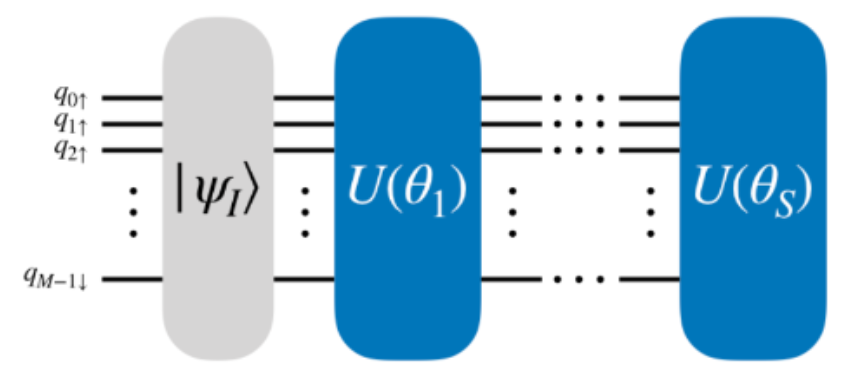

Each unitary rotation $U(\theta_j)$ is further divided into products of rotations with respect to different terms in the Hamiltonian, i.e.

\begin{equation*}
    U(\theta_j) = e^{i\theta_jH} = e^{i\theta_{j,xe}H_{xe}}e^{i\theta_{j,xo}H_{xo}}e^{i\theta_{j,ye}H_{ye}}e^{i\theta_{j,yo}H_{yo}}e^{i\theta_{j,z}H_{U}}
\end{equation*}

where $H_{x\lor{}y,e \lor o}$ denotes $e$ for even, $o$ for odd, and $x$ and $y$ are the hopping terms, i.e. $XX$ and $YY$. Therefore, there are $5S$ variational parameters in total. Each of the unitary rotations above must be converted into basic gates for implementation on a quantum computer. 

----------------------------------------

The time evolution operators $U(\theta_j)$ are composed of unitary rotations with respect to different terms of the Hamiltonian:

\begin{equation*}
    U(\theta_j) = e^{i\theta_j \left( H_0 + H_U \right)} = e^{i\theta_{j, xe}H_{xe}}e^{i\theta_{j, xo}H_{xo}}e^{i\theta_{j, ye}H_{ye}}e^{i\theta_{j, yo}H_{yo}}e^{i\theta_{j, z}H_{U}}             
\end{equation*}

where 

\begin{align*}
    e^{i\theta_{j, xe}H_{xe}} = \Pi_{\sigma} \Pi_{i=2k} e^{-i\frac{t}{2}\theta_{j, xe}X_{i \sigma} X_{i+1\sigma}} \\
    e^{i\theta_{j, ye}H_{ye}} = \Pi_{\sigma} \Pi_{i=2k} e^{-i\frac{t}{2}\theta_{j, ye}Y_{i \sigma} Y_{i+1\sigma}} \\
    e^{i\theta_{j, z}H_{U}} = \Pi_{i}e^{i\frac{U}{4}\theta_{j, z}\left( I - Z_{i \uparrow} - Z_{i \downarrow} + Z_{i \uparrow}Z_{i \downarrow} \right)}
\end{align*}

Therefore, it suffice to find sequences of basic gates that implement $XX$, $YY$, and $ZZ$ interactions described by unitary rotations $e^{i \theta X_i X_j}$, $e^{i \theta Y_i Y_j}$, and $e^{i \theta \left( I - Z_{i\uparrow} - Z_{i\downarrow} + Z_{i\uparrow}Z_{i\downarrow} \right)}$ repesctively. 

#### XX Interaction

The Taylor expansion for $e^{i \theta X_i X_j}$ is as follows:

\begin{multline*}
    e^{i \theta X_i X_j} = I + \frac{i}{1!}\theta^1 X_i X_j - \frac{i}{2!}\theta^2 I - \frac{i}{3!}\theta^3 X_i X_j + ... \\ 
    = \left[ I - \frac{\theta^2}{2!} + \frac{\theta^4}{4!} + ... \right] + iX_i X_j \left[ \frac{\theta}{1!} - \frac{\theta^3}{3!} + ... \right] = Icos(\theta) + i X_i X_j sin(\theta)
\end{multline*}

This can be written in matrix form as 

\begin{equation*}
    e^{i \theta X_i X_j} = 
    \begin{pmatrix} 
    cos(\theta) & 0 & 0 & isin(\theta) \\ 
    0 & cos(\theta) & isin(\theta) & 0 \\
    0 & isin(\theta) & cos(\theta) & 0 \\
    isin(\theta) & 0 & 0 & cos(\theta)
    \end{pmatrix}
\end{equation*}

This matrix represents a two-qubit gate which cannot be written as a tensor product of two single-qubit gates. After some algebra one obtains the sequence of basic gates that implements this matrix on qubits $i$ and $j$ as follows

\begin{equation*}
    e^{i \theta X_i X_j} = CX_{i} \cdot Rx_{i}(\theta) \otimes I_{j} \cdot CX_{i}
\end{equation*}

where $CX_{i}$ denotes a CNOT gate between qubits $i$ and $j$ where qubit $i$ is the control. 

#### YY Interaction

In a similar manner as above, we can get that $e^{i\theta Y_{i}Y_{j}} = I cos(\theta) + i Y_{i}Y_{j} sin(\theta)$. Therefore, 

\begin{equation*}
    e^{i \theta Y_i Y_j} = 
    \begin{pmatrix} 
    cos(\theta) & 0 & 0 & -isin(\theta) \\ 
    0 & cos(\theta) & isin(\theta) & 0 \\
    0 & isin(\theta) & cos(\theta) & 0 \\
    -isin(\theta) & 0 & 0 & cos(\theta)
    \end{pmatrix}
\end{equation*}

Which can be used to backtrack to the following sequence of gates. 

\begin{equation*}
    e^{i \theta Y_i Y_j} = CX_{i} \cdot I_{i} \otimes H_{j} \cdot CX_{j} \cdot I_{i} \otimes Rx{j}(-\theta) \cdot CX_{j} \cdot I_{i} \otimes H_{j} \cdot CX_{i}
\end{equation*}

Since the $XX$ interaction ends with a CNOT gate and the YY interaction starts with a CNOT gate, the depth of the circuit can be reduced by three by placing $XX$ and $YY$ interactions in series. That is because the two CNOT gates cancel each other out and the $Rx_{i}(\theta)$ can be implemented in parallel with $H_{j}$ because $Rx_{i}(\theta) \otimes I_{j} \cdot I_{i} \otimes H_{j} = Rx_{i}(\theta) \otimes H_{j}$. Therefore, on obtains

\begin{gather*}
    e^{i \theta X_i X_j} e^{i \theta Y_i Y_j} = \\ 
    CX_{i} \cdot Rx_{i}(\theta) \otimes H_{j} \cdot CX_{j} \cdot I_{i} \otimes Rx{j}(-\theta) \cdot CX_{j} \cdot I_{i} \otimes H_{j} \cdot CX_{i}
\end{gather*}

#### ZZ Interaction

Similarly, it can be shown that

\begin{equation*}
    e^{i \theta \left(I - Z_{i \uparrow} - Z_{i \downarrow} + Z_{i \uparrow}Z_{i \downarrow} \right)} = 
    \begin{pmatrix} 
    1 & 0 & 0 & 0 \\ 
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & e^{i \theta}
    \end{pmatrix} = cRz(\theta)
\end{equation*}

which is simply implemented by a controlled Z rotation, where qubit $i \uparrow$ is the control and $i \downarrow$ is the target. The fifure below illustrates the final unitary rotation circuit $U(\theta_{j})$ for a lattice with $M=3$ orbitals where $q[0]$, $q[1]$, and $q[2]$ represent spin-up states and $q[3]$, $q[4]$, and $q[5]$ represent spin-down states. 

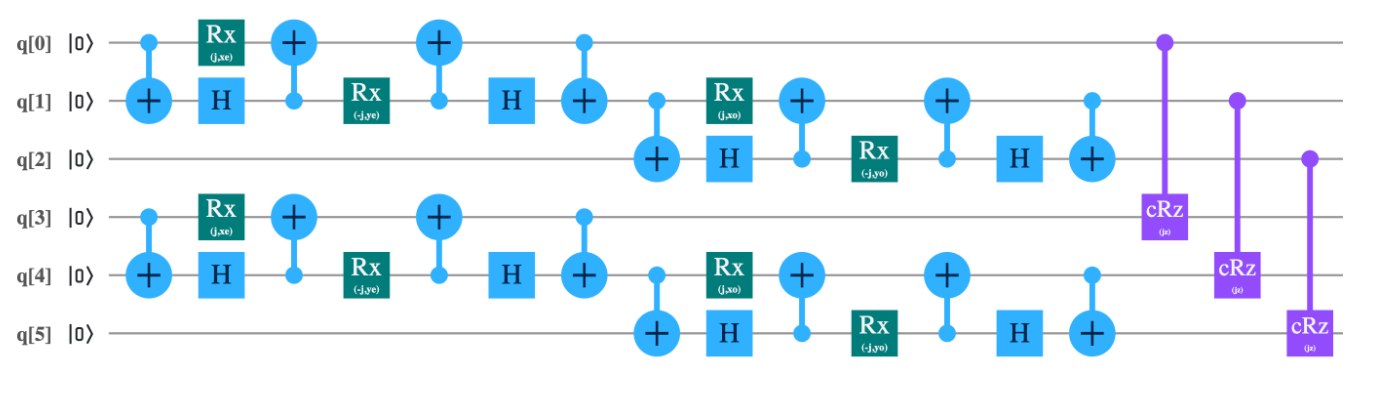

Even XX and YY interaction until the second to last CNOT/before the last Hadamard--odd XX and YY interactions after. 

### Energy Measurement

Given the ansatz wavefunction $\psi(\theta)$, one needs to measure the energy of the system which is the expectation value of the Hamiltonian, i.e. $E(\theta) = \langle \psi(\theta)|H|\psi(\theta)\rangle$. Decomposing $H$ into 5 commuting terms as before--i.e., $H = H_{xe} + H_{xo} + H_{ye} + H_{yo} + H_{U}$--one obtains, 

\begin{equation*}
    E(\theta) = \langle H_{xe }\rangle + \langle H_{xo }\rangle + \langle H_{ye }\rangle + \langle H_{yo }\rangle + \langle H_{U}\rangle
\end{equation*}. 

This allows the energy contribution of each term to be measured separately before adding them together. Therefore, the measurement circuit for each term will only be of depeth 1, i.e. $X$ gates for $H_{x, e \lor o}$ and $Y$ gates for $H_{y, e \lor o}$. There does not need to be any circuit to measure the energy of $H_U$ since one only needs to measure the number of occupancies which is done by measuring the wavefunction directly. It is worth noting that a large number of measurements are required to get an accurate estimate of the energy, which is one of the biggest downsides of the VQE algorithm. 



# Implemenation and Code

[Initial State] ---> [Ansatz Circuit (parameterized)] ---> [Basis Rotation for Measurement] ---> [Measurement]


In [62]:
import numpy as np 
from copy import deepcopy
from qiskit import *

In [63]:
M = 5 # number of lattice sites
t = 1.0 # hopping energy
U = 0.1 # Coulomb potential 
Nu = 3 # number of spin-up electrons
Nd = 3 # number of spin-down electrons

S = 3 # number of Trotter-Suzuki steps
theta = np.random.rand(S, 5) # 5 Hamiltonian terms in each step

In [64]:
empty_circuit = QuantumCircuit(2*M) # initialize circuit, 2*M for each spin state per lattice site

In [72]:
# compose quantum circuit

def compose_initial_circuit(circuit, _M, _Nu, _Nd):
    '''
    This function generates the initial wavefunction \psi_I 
    which is the solution to the non-interacting Hamiltonain H_0
    and depends on the filling factor of the system, i.e. Nu and Nd. 
    This function initializes the spin-up electrons on qubits 0 to
    Nu - 1 and the spin-down electrons on qubits M to M + Nd - 1. 
    
    Apply X gates to populate the first Nu qubits (spin-up)
    Apply X gates to the next Nd qubits (spin-down)
    
    Physically, the electrons are being placed into the lowest orbitals of the lattice
    '''
    for i in range(_Nu):
        circuit.x(i)
    for i in range(_Nd):
        circuit.x(_M+i)
    return circuit

def compose_ansatz_circuit(circuit, _M, _S, _theta):
    '''
    This function generates the parameterized ansatz wavfunction. 
    The variational parameters theta are given as an input. 
    '''
    # scale theta based on hopping parameter t and Coulomb energy U
    _theta[:, :4] = -0.5*t*_theta[:, :4] # hopping term
    _theta[:, 4] = U*_theta[:, 4] # interaction term
    # loop over S Trotter-Suzuki steps
    for j in range(_S):
        # XX and YY interactions: loop over even and odd terms
        for parity in [0, 1]: # even and odd parity
            # loop over orbitals
            for i in range(_M-1):
                if i%2 == parity:
                    # loop over spin-up and -down qubits
                    for spin_index in [0, _M]:
                        circuit.cx(spin_index+i, spin_index+i+1)
                        circuit.rx(_theta[j, 2*parity+0], spin_index+i) # theta_j, x(e/o)
                        circuit.h(spin_index+i+1)
                        circuit.cx(spin_index+i+1, spin_index+i)
                        circuit.rx(-_theta[j, 2*parity+1], spin_index+i+1) # theta_j, y(e/o)
                        circuit.cx(spin_index+i+1, spin_index+i)
                        circuit.h(spin_index+i+1)
                        circuit.cx(spin_index+i, spin_index+i+1)
        # barrier
        circuit.barrier()
        # ZZ interactions
        # loop over orbitals
        for i in range(_M):
            circuit.crz(_theta[j, 4], i, _M+i)
    return circuit

def compose_measurement_circuit(circuit, _M, which_term):
    '''
    This function implements the circuit for energy measurement. 
    The argument which_term denotes the Hamiltonian terms:
    xe, xo, ye, yo, and z. 
    '''
    if which_term == "xe":
        for i in range(_M-1):
            circuit.h(i)
            circuit.h(_M+i)
    elif which_term == "xo":
        for i in range(_M-1):
            circuit.x(i+1)
            circuit.x(_M+i+1)
    elif which_term == "ye":
        for i in range(_M-1):
            circuit.y(i)
            circuit.y(_M+i)
    elif which_term == "yo":
        for i in range(_M-1):
            circuit.y(i+1)
            circuit.y(_M+i+1)
    else:
        pass
    return circuit

In [66]:
initial_circuit = compose_initial_circuit(deepcopy(empty_circuit), M, Nu, Nd)
#initial_circuit.draw()                  

In [71]:
ansatz_circuit = compose_ansatz_circuit(deepcopy(empty_circuit), M, S, theta)
#ansatz_circuit.draw() 

In [68]:
measurement_circuit = compose_measurement_circuit(deepcopy(empty_circuit), M, "xe")
#measurement_circuit.draw()

In [69]:
#complete_circuit = initial_circuit + ansatz_circuit + measurement_circuit
complete_circuit = initial_circuit.compose(ansatz_circuit).compose(measurement_circuit)
complete_circuit.draw()

┌───┐     ┌───────────────┐┌───┐              ┌───┐               »
q_0: ┤ X ├──■──┤ Rx(-0.049163) ├┤ X ├──────────────┤ X ├───────■───────»
     ├───┤┌─┴─┐└─────┬───┬─────┘└─┬─┘┌────────────┐└─┬─┘┌───┐┌─┴─┐     »
q_1: ┤ X ├┤ X ├──────┤ H ├────────■──┤ Rx(0.4231) ├──■──┤ H ├┤ X ├──■──»
     ├───┤└───┘┌─────┴───┴─────┐┌───┐└────────────┘┌───┐└───┘└───┘┌─┴─┐»
q_2: ┤ X ├──■──┤ Rx(-0.049163) ├┤ X ├──────────────┤ X ├───────■──┤ X ├»
     └───┘┌─┴─┐└─────┬───┬─────┘└─┬─┘┌────────────┐└─┬─┘┌───┐┌─┴─┐└───┘»
q_3: ─────┤ X ├──────┤ H ├────────■──┤ Rx(0.4231) ├──■──┤ H ├┤ X ├──■──»
          └───┘      └───┘           └────────────┘     └───┘└───┘┌─┴─┐»
q_4: ─────────────────────────────────────────────────────────────┤ X ├»
     ┌───┐     ┌───────────────┐┌───┐              ┌───┐          └───┘»
q_5: ┤ X ├──■──┤ Rx(-0.049163) ├┤ X ├──────────────┤ X ├───────■───────»
     ├───┤┌─┴─┐└─────┬───┬─────┘└─┬─┘┌────────────┐└─┬─┘┌───┐┌─┴─┐     »
q_6: ┤ X ├┤ X ├──────┤ H ├────────■──┤ Rx(0.4231) ├──■──┤ H ├┤ X ├──■──»
     ├───┤└───┘┌─────┴───┴─────┐┌───┐└────────────┘┌───┐└───┘└───┘┌─┴─┐»
q_7: ┤ X ├──■──┤ Rx(-0.049163) ├┤ X ├──────────────┤ X ├───────■──┤ X ├»
     └───┘┌─┴─┐└─────┬───┬─────┘└─┬─┘┌────────────┐└─┬─┘┌───┐┌─┴─┐└───┘»
q_8: ─────┤ X ├──────┤ H ├────────■──┤ Rx(0.4231) ├──■──┤ H ├┤ X ├──■──»
          └───┘      └───┘           └────────────┘     └───┘└───┘┌─┴─┐»
q_9: ─────────────────────────────────────────────────────────────┤ X ├»
                                                                  └───┘»
«                                                        ░                 »
«q_0: ───────────────────────────────────────────────────░────────■────────»
«     ┌─────────────┐┌───┐               ┌───┐           ░        │        »
«q_1: ┤ Rx(-0.2694) ├┤ X ├───────────────┤ X ├───────■───░────────┼────────»
«     └────┬───┬────┘└─┬─┘┌─────────────┐└─┬─┘┌───┐┌─┴─┐ ░        │        »
«q_2: ─────┤ H ├───────■──┤ Rx(0.45371) ├──■──┤ H ├┤ X ├─░────────┼────────»
«     ┌────┴───┴────┐┌───┐└─────────────┘┌───┐└───┘└───┘ ░        │        »
«q_3: ┤ Rx(-0.2694) ├┤ X ├───────────────┤ X ├───────■───░────────┼────────»
«     └────┬───┬────┘└─┬─┘┌─────────────┐└─┬─┘┌───┐┌─┴─┐ ░        │        »
«q_4: ─────┤ H ├───────■──┤ Rx(0.45371) ├──■──┤ H ├┤ X ├─░────────┼────────»
«          └───┘          └─────────────┘     └───┘└───┘ ░ ┌──────┴───────┐»
«q_5: ───────────────────────────────────────────────────░─┤ Rz(0.019228) ├»
«     ┌─────────────┐┌───┐               ┌───┐           ░ └──────────────┘»
«q_6: ┤ Rx(-0.2694) ├┤ X ├───────────────┤ X ├───────■───░─────────────────»
«     └────┬───┬────┘└─┬─┘┌─────────────┐└─┬─┘┌───┐┌─┴─┐ ░                 »
«q_7: ─────┤ H ├───────■──┤ Rx(0.45371) ├──■──┤ H ├┤ X ├─░─────────────────»
«     ┌────┴───┴────┐┌───┐└─────────────┘┌───┐└───┘└───┘ ░                 »
«q_8: ┤ Rx(-0.2694) ├┤ X ├───────────────┤ X ├───────■───░─────────────────»
«     └────┬───┬────┘└─┬─┘┌─────────────┐└─┬─┘┌───┐┌─┴─┐ ░                 »
«q_9: ─────┤ H ├───────■──┤ Rx(0.45371) ├──■──┤ H ├┤ X ├─░─────────────────»
«          └───┘          └─────────────┘     └───┘└───┘ ░                 »
«                                     ┌──────────────┐     ┌───┐      »
«q_0: ───────────────────────■────────┤ Rx(-0.18201) ├─────┤ X ├──────»
«                          ┌─┴─┐      └────┬───┬─────┘     └─┬─┘      »
«q_1: ───────■─────────────┤ X ├───────────┤ H ├─────────────■────────»
«            │             └───┘           └───┘                      »
«q_2: ───────┼───────────────■───────────────────────────────■────────»
«            │               │                             ┌─┴─┐      »
«q_3: ───────┼───────────────┼───────────────■─────────────┤ X ├──────»
«            │               │               │             └───┘      »
«q_4: ───────┼───────────────┼───────────────┼───────────────■────────»
«            │               │               │               │        »
«q_5: ───────┼───────────────┼───────────────┼───────────────┼─

In [77]:
import numpy as np
from copy import deepcopy
from qiskit import QuantumCircuit, transpile
import qiskit_aer as aer
from qiskit.visualization import plot_histogram
from scipy.optimize import minimize


# Parameters
M = 5        # number of lattice sites
t = 1.0      # hopping energy
U = 0.1      # Coulomb potential
Nu = 3       # spin-up electrons
Nd = 3       # spin-down electrons
S = 3        # number of Trotter steps
theta = np.random.rand(S, 5)  # variational parameters

empty_circuit = QuantumCircuit(2*M)

# Initial State
def compose_initial_circuit(circuit, _M, _Nu, _Nd):
    for i in range(_Nu):
        circuit.x(i)
    for i in range(_Nd):
        circuit.x(_M+i)
    return circuit

# Ansatz
def compose_ansatz_circuit(circuit, _M, _S, _theta):
    _theta = deepcopy(_theta)  # avoid modifying input
    _theta[:, :4] = -0.5 * t * _theta[:, :4]
    _theta[:, 4] = U * _theta[:, 4]
    
    for j in range(_S):
        for parity in [0, 1]:  # include both even and odd bonds
            for i in range(_M-1):
                if i % 2 == parity:
                    for spin_index in [0, _M]:  # spin-up and spin-down
                        circuit.cx(spin_index+i, spin_index+i+1)
                        circuit.rx(_theta[j, 2*parity], spin_index+i)
                        circuit.h(spin_index+i+1)
                        circuit.cx(spin_index+i+1, spin_index+i)
                        circuit.rx(-_theta[j, 2*parity+1], spin_index+i+1)
                        circuit.cx(spin_index+i+1, spin_index+i)
                        circuit.h(spin_index+i+1)
                        circuit.cx(spin_index+i, spin_index+i+1)
        circuit.barrier()
        for i in range(_M):
            circuit.crz(_theta[j, 4], i, _M+i)
    return circuit

# Measurement
def compose_measurement_circuit(circuit, _M, which_term):
    if which_term == "xe":
        for i in range(_M-1):
            if i % 2 == 0:
                circuit.h(i)
                circuit.h(_M+i)
    elif which_term == "xo":
        for i in range(_M-1):
            if i % 2 == 1:
                circuit.h(i)
                circuit.h(_M+i)
    elif which_term == "ye":
        for i in range(_M-1):
            if i % 2 == 0:
                circuit.sdg(i)
                circuit.h(i)
                circuit.sdg(_M+i)
                circuit.h(_M+i)
    elif which_term == "yo":
        for i in range(_M-1):
            if i % 2 == 1:
                circuit.sdg(i)
                circuit.h(i)
                circuit.sdg(_M+i)
                circuit.h(_M+i)
    elif which_term == "z":
        pass  # no need for rotation
    return circuit

# Full circuit build
def build_full_circuit(theta, which_term):
    init_circ = compose_initial_circuit(deepcopy(empty_circuit), M, Nu, Nd)
    ansatz_circ = compose_ansatz_circuit(deepcopy(empty_circuit), M, S, theta)
    meas_circ = compose_measurement_circuit(deepcopy(empty_circuit), M, which_term)
    full_circ = init_circ.compose(ansatz_circ).compose(meas_circ)
    full_circ.measure_all()
    return full_circ


In [79]:
# Hamiltonian coefficients
coeffs = {
    "xe": -t,
    "xo": -t,
    "ye": -t,
    "yo": -t,
    "z": U
}

terms = ["xe", "xo", "ye", "yo", "z"]

simulator = aer.AerSimulator()

# Expectation value calculation
def get_expectation(theta):
    energy = 0.0
    for term in terms:
        circ = build_full_circuit(theta, term)
        circ = transpile(circ, simulator)
        result = simulator.run(circ, shots=1024).result()
        counts = result.get_counts()

        # Compute expectation value of Z measurement (basic)
        expval = 0
        for bitstring, count in counts.items():
            parity = (-1)**(bitstring.count('1'))
            expval += parity*count
        expval /= 1024
        
        energy += coeffs[term] * expval
    return energy

# Optimization
initial_theta = np.random.rand(S, 5)
result = minimize(lambda th: get_expectation(th.reshape(S,5)), initial_theta.flatten(), method='COBYLA')

print("Optimal energy:", result.fun)
print("Optimal theta:", result.x.reshape(S,5))

Optimal energy: -0.3453125
Optimal theta: [[0.53863511 1.48728987 1.59863893 0.85606754 1.55513393]
 [1.27746571 0.03002451 0.18512886 0.50766172 0.5214721 ]
 [0.57772973 0.58890346 0.46353695 0.86346848 0.27005492]]
